In [1]:
import matplotlib.pyplot as plt
import numpy as np

import geopandas as gpd
from shapely.ops import unary_union
import datetime as dt

from sentinelhub import UtmZoneSplitter, CRS, BBox, WcsRequest, MimeType, CustomUrlParam

### Load shapefile, get geometries

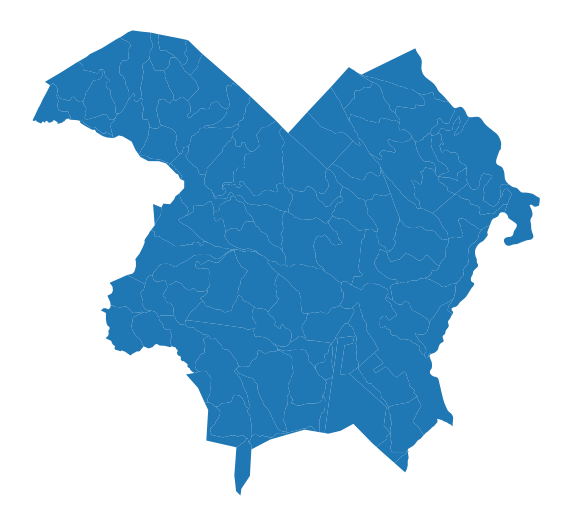

In [2]:
# load shapefile
gdf = gpd.read_file('krokar_vector/krokar_vector.shp')

# set crs (info obtained elsewhere)
gdf.crs = CRS(3912).epsg

# reproject to UTM 33N
gdf = gdf.to_crs(CRS.UTM_33N.epsg)

# plot dataframe
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax)
plt.axis('off');

### Create bounding box for request

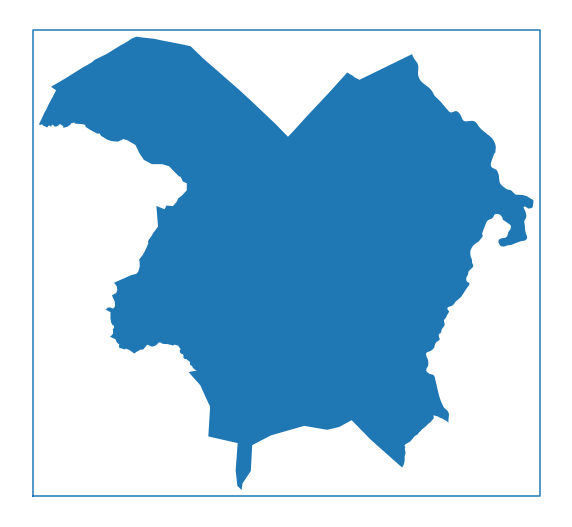

In [125]:
# unify geometries and take only outline
geo = unary_union(gdf.geometry)
gdf = gpd.GeoDataFrame(None, geometry=[geo], crs=gdf.crs)

# buffer for 100 m and get bbox
bbox_geo = gdf.buffer(100).envelope[0]

# plot bbox
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax)

x,y = bbox_geo.exterior.xy
plt.plot(x,y)

plt.axis('off');

In [126]:
# sentinelhub bbox
krokar_bbox = BBox(bbox=bbox_geo, crs=CRS.UTM_33N)

# evalscript to download only bands for RGB
# output is [R, G, B]
rgb_evalscript = '''
return [B04, B03, B02];
'''

# evalscript to download only bands for NDVI
# NDVI is (B08 - B04) / (B08 + B04);
# output is [NDVI]
ndvi_evalscript = '''
var ndvi = (B08 - B04)/(B08 + B04);
return [ndvi];
'''

# build a RGB request
wcs_rgb_request = WcsRequest(
    data_folder='krokar_rgb_data',
    layer='BANDS-S2-L1C',
    bbox=krokar_bbox,
    time=('2019-01-01', '2019-12-31'),
    time_difference=dt.timedelta(hours=2),
    resx='10m',
    resy='10m',
    maxcc=0.3,  # max cloud coverage per tile 10 %
    image_format=MimeType.TIFF_d32f,
    custom_url_params={CustomUrlParam.EVALSCRIPT: rgb_evalscript},
)

# build an NDVI request
wcs_ndvi_request = WcsRequest(
    data_folder='krokar_ndvi_data',
    layer='BANDS-S2-L1C',
    bbox=krokar_bbox,
    time=('2019-01-01', '2019-12-31'),
    time_difference=dt.timedelta(hours=2),
    resx='10m',
    resy='10m',
    maxcc=0.8,  # max cloud coverage per tile 10 %
    image_format=MimeType.TIFF_d32f,
    custom_url_params={CustomUrlParam.EVALSCRIPT: ndvi_evalscript},
)

# download data
rgb = np.array(wcs_rgb_request.get_data(save_data=True))
ndvi = np.array(wcs_ndvi_request.get_data(save_data=True))

In [127]:
# how many images in a year?
print(len(rgb_img))

# get min and max of ndvi data
ndvi_min = np.min(ndvi_img)
ndvi_max = np.max(ndvi_img)

27


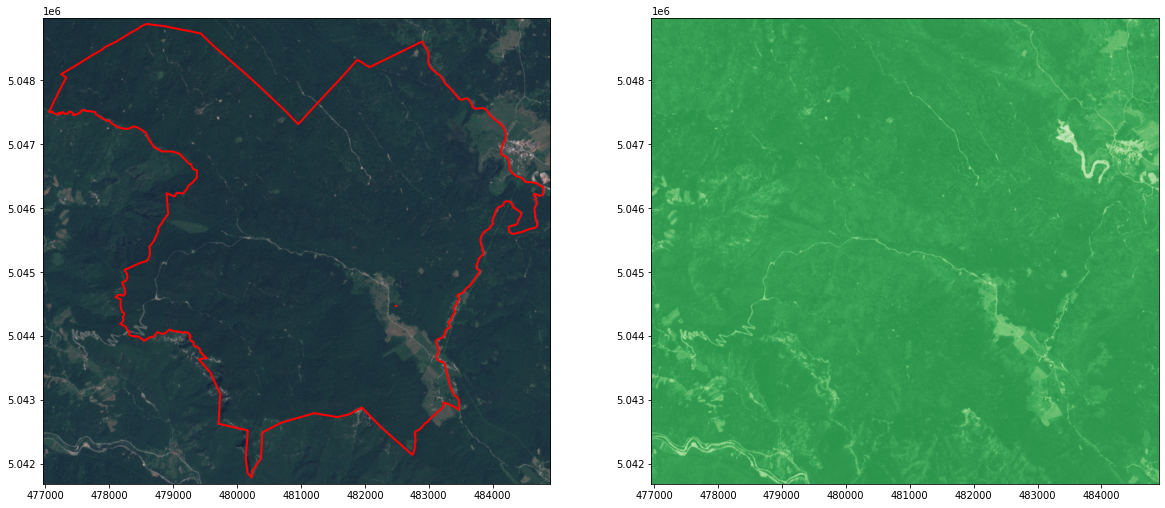

In [133]:
# set image extent to overlay ndvi raster data and vector data
extent=np.array(krokar_bbox.geometry.bounds)[[0,2,1,3]]

time_idx = 12

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))

ax[0].imshow(rgb[time_idx]*3.5, extent = extent)
gdf.plot(ax=ax[0], facecolor='None',edgecolor='r', lw=2)

ax[1].imshow(ndvi[time_idx], extent = extent, cmap=plt.cm.Greens, vmin=ndvi_min, vmax=ndvi_max)
#gdf.plot(ax=ax[1], facecolor='None',edgecolor='r', lw=2)